In [6]:
import pickle
import argparse
import os
import torch
import math
# import xlsxwriter
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import numpy
from scipy.optimize import curve_fit
import random
import torch.optim as optim
import time
import torch.nn as nn

In [7]:
class View(torch.nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)
    
class AlexNet(torch.nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    # Define the layers
    self.layers = torch.nn.Sequential(*[torch.nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                                        torch.nn.BatchNorm2d(96), 
                                        torch.nn.ReLU(), 
                                        torch.nn.MaxPool2d(kernel_size = 3, stride = 2), 
                                        torch.nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
            torch.nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(384),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(384),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
            View((-1, 9216)),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(9216, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, num_classes)])
    # Define the corresponding masks if the layer has weight
    self.masks = torch.nn.ParameterList([torch.nn.Parameter(torch.Tensor(torch.ones(self.layers[i].weight.data.shape)), requires_grad=False) \
                                         for i in range(len(self.layers)) \
                                         if hasattr(self.layers[i], 'weight')])
    
  def forward(self, x):
    # First multiply each layer's weights with its corresponding mask
    with torch.no_grad():
      j = 0
      for i in range(len(self.layers)):
        if hasattr(self.layers[i], 'weight'):
          self.layers[i].weight.copy_(self.layers[i].weight.data * self.masks[j])
          j += 1
        else:
          pass
    return self.layers(x)

In [8]:
def lognormal_like(x, a, mu, c):
    
    logx=[math.log(x[i]) for i in range(len(x))]
    return a*(1/(2.5*x*c)) * numpy.exp(-(logx - mu)**2 / (2 * c**2))

def weight_ext1(model):
    model.to('cpu')
    #workbook = xlsxwriter.Workbook("BERT\\Alexnet.xlsx")
    layer=0
    layer1=[]
    maxi1=[]
    mini1=[]
    total_count=[]
    A=[]
    MU=[]
    SIGMA=[]
    R2=[]
    W=[]
    Wt_range=[]
    b=[]
    y_=[]
    y_shape=[]
    i=0
    leni=0
    tot=0
    for name, param in model.named_parameters():
    
        w=name.split('.')[len(name.split('.'))-1]
        print(w)
        if w=='bias':
            bias=param.data.numpy()
            bias=bias.flatten()
            b.append(bias)

        if w=='weight':
            layer+=1
            print(layer)
            weight=param.data.numpy()
            print(np.shape(weight))
            y_shape.append(np.shape(weight))
            if layer>=6 or True:
                layer1.append(layer)
                #worksheet = workbook.add_worksheet('Layer-'+str(layer))


                #if len(param.data.shape)==2:
                weight=param.data.numpy()
                weight=weight.flatten()
                maxi=numpy.max(weight)
                mini=numpy.min(weight)
                mini1.append(int(mini*1000)/1000)
                maxi1.append(int(maxi*1000)/1000)
                
                weight=numpy.absolute(weight)
                W.append(sum(weight))
                print(weight.shape,maxi,mini)
                total_count.append(len(weight))

                weight_ass=sorted(weight)
                leni+=len(weight_ass)
                weight_ass=weight_ass/max(weight_ass)

                weight_ass=weight_ass*1000
                weight_ass = weight_ass.astype(int)
                weight_ass=weight_ass/1000

                prev=weight_ass[0]
                weight_bin=[]
                cnt=[]
                count=1
                cum_count=[]
                log_norm=[]
                log_norm_percent=[]

                for i in range(len(weight_ass)):
                    try:
                        if weight_ass[i]<=prev:
                            count+=1
                        else:

                            cnt.append(count)
                            #cum_count.append()
                            prev=weight_ass[i]
                            weight_bin.append(prev)
                            log_norm.append(prev*count)
                            count=1
                            #print(i)
                    except:
                        print('except',i)
                        pass
                count_percent=100*numpy.array(cnt)/sum(cnt)
                cum_count=numpy.cumsum(cnt, dtype=float)
                cum_count_percent=100*numpy.array(cum_count)/cum_count[len(cum_count)-1]
                log_norm_percent=100*numpy.array(log_norm)/numpy.sum(log_norm)
                x_data = numpy.array(weight_bin)
                y_data = numpy.array(log_norm)
                left, width = .25, .65
                bottom, height = .25, .95
                right = left + width
                top = bottom + height

                try:
                    popt, _ = curve_fit(lognormal_like, x_data, y_data, p0=(1,0,2))
                    a_fit, mu, sigma = popt
                    A.append(int(a_fit*1000)/1000)
                    MU.append(int(mu*1000)/1000)
                    SIGMA.append(int(sigma*1000)/1000)

                    y_fit = lognormal_like(x_data, a_fit, mu, sigma)
                    y_.append(popt)

                    residuals = y_data - y_fit
                    rss = numpy.sum(residuals**2)
                    rmse = numpy.sqrt(numpy.mean(residuals**2))
                    total_sum_of_squares = numpy.sum((y_data - numpy.mean(y_data))**2)
                    r_squared = 1 - (rss / total_sum_of_squares)
                    R2.append(int(r_squared*1000)/1000)

                    img = np.ones((256,256,3), np.uint8)*255
                    width,height,_=img.shape
                    fig, axes = plt.subplots()
                    x_rel = 0.60
                    y_rel = 0.95

                    axes.scatter(x_data, y_data, label='Data')
                    axes.plot(x_data, y_fit, 'r-', label='Fitted Curve')
                    #axes.legend()

                    total_c=str(format(len(weight), ','))
                    total_w=str(format(int(sum(weight)), ','))
                    axes.text(x_rel, y_rel, 'Total Weight : '+total_w, fontsize=11, transform=axes.transAxes)
                    axes.text(x_rel, y_rel - 0.07, 'Total Count : '+total_c, fontsize=11, transform=axes.transAxes)
                    axes.text(x_rel, y_rel - 0.14, '$R^2$ : '+str(int(r_squared*1000)/1000), fontsize=11, transform=axes.transAxes)
                    axes.text(x_rel, y_rel - 0.21, "A' : "+str(int(a_fit*1000)/1000), fontsize=11, transform=axes.transAxes)
                    axes.text(x_rel, y_rel - 0.28, "$\mu'$ : "+str(int(mu*1000)/1000), fontsize=11, transform=axes.transAxes)
                    axes.text(x_rel, y_rel - 0.35,"$\sigma'$ : "+str(int(sigma*1000)/1000), fontsize=11, transform=axes.transAxes)

                    #axes.title('R2-'+str(int(r_squared*1000)/1000))
                    axes.set_xlabel('Normalized Weight')
                    axes.set_ylabel('Category Weight')
                    #plt.xlim([-0.05, 0.5])
                    plt.gca().title.set_text('FC: Layer '+str(layer))
                    plt.show()


                except:
                    print('False')
                    plt.scatter(x_data, y_data, label='Data')
                    #plt.legend()
                    plt.title('FC: Layer '+str(layer))
                    plt.xlabel('Normalized Weight')
                    #plt.text(.01, .99, 'matplotlib', ha='left', va='top', transform=axes.transAxes)
                    plt.ylabel('Category Weight')
                    img = np.ones((256,256,3), np.uint8)*255
                    width,height,_=img.shape

                    #plt.savefig("Alexnet\\"+str(layer)+'.png')
                    #plt.close()
                    #A.append(0)
                    #MU.append(0)
                    #SIGMA.append(0)
                    #R2.append(0)
                    #worksheet.insert_image('L8',"Alexnet\\"+ str(layer)+'.png')
                    plt.show()
                    pass
        
    print(len(b),'lenght of bias')
    return y_,y_shape,maxi1

    #workbook.close()

def weight_count(model):
    model.to('cpu')
    workbook = xlsxwriter.Workbook("FC_count.xlsx")
    layer=0
    layer1=[]
    maxi1=[]
    mini1=[]
    total_count=[]
    A=[]
    MU=[]
    SIGMA=[]
    R2=[]
    W=[]
    Wt_range=[]
    b=[]
    y_=[]
    y_shape=[]
    i=0
    leni=0
    tot=0
    for name, param in model.named_parameters():
    
        w=name.split('.')[len(name.split('.'))-1]
        print(w)
        if w=='bias':
            bias=param.data.numpy()
            bias=bias.flatten()
            b.append(bias)

        if w=='weight':
            layer+=1
            print(layer)
            weight=param.data.numpy()
            print(np.shape(weight))
            y_shape.append(np.shape(weight))
            if layer>=6 or True:
                layer1.append(layer)
                worksheet = workbook.add_worksheet('Layer-'+str(layer))


                #if len(param.data.shape)==2:
                weight=param.data.numpy()
                weight=weight.flatten()
                maxi=numpy.max(weight)
                mini=numpy.min(weight)
                mini1.append(int(mini*1000)/1000)
                maxi1.append(int(maxi*1000)/1000)
                
                weight=numpy.absolute(weight)
                W.append(sum(weight))
                print(weight.shape,maxi,mini)
                total_count.append(len(weight))

                weight_ass=sorted(weight)
                leni+=len(weight_ass)
                weight_ass=weight_ass/max(weight_ass)

                weight_ass=weight_ass*1000
                weight_ass = weight_ass.astype(int)
                weight_ass=weight_ass/1000

                prev=weight_ass[0]
                weight_bin=[]
                cnt=[]
                count=1
                cum_count=[]
                log_norm=[]
                log_norm_percent=[]

                for i in range(len(weight_ass)):
                    try:
                        if weight_ass[i]<=prev:
                            count+=1
                        else:

                            cnt.append(count)
                            #cum_count.append()
                            prev=weight_ass[i]
                            weight_bin.append(prev)
                            log_norm.append(prev*count)
                            count=1
                            #print(i)
                    except:
                        print('except',i)
                        pass
                count_percent=100*numpy.array(cnt)/sum(cnt)
                cum_count=numpy.cumsum(cnt, dtype=float)
                cum_count_percent=100*numpy.array(cum_count)/cum_count[len(cum_count)-1]
                log_norm_percent=100*numpy.array(log_norm)/numpy.sum(log_norm)
                x_data = numpy.array(weight_bin)
                y_data = numpy.array(cnt)
                left, width = .25, .65
                bottom, height = .25, .95
                right = left + width
                top = bottom + height

                try:
                    img = np.ones((256,256,3), np.uint8)*255
                    width,height,_=img.shape
                    fig, axes = plt.subplots()
                    x_rel = 0.60
                    y_rel = 0.95

                    axes.scatter(x_data, y_data, label='Data')
                    
                    total_c=str(format(len(weight), ','))
                    total_w=str(format(int(sum(weight)), ','))
                    axes.text(x_rel, y_rel, 'Total Weight : '+total_w, fontsize=11, transform=axes.transAxes)
                    axes.text(x_rel, y_rel - 0.07, 'Total Count : '+total_c, fontsize=11, transform=axes.transAxes)
                    
                    #axes.title('R2-'+str(int(r_squared*1000)/1000))
                    axes.set_xlabel('Normalized Weight')
                    axes.set_ylabel('Count')
                    #plt.xlim([-0.05, 0.5])
                    plt.gca().title.set_text('FC: Layer '+str(layer))
                    plt.savefig(f"FC\\"+str(layer)+'.png')
                    plt.show()


                except:
                    print('False')
                    
                worksheet.write_column(1, 0,weight_bin)
                worksheet.write_column(1, 1,cnt)
                worksheet.write_column(1, 2,log_norm)

                worksheet.write(0, 1,'Count')
                worksheet.write(0, 2,'Cat Weight')
                worksheet.write(0, 3,'Total Weight')
                worksheet.write(1, 3,len(weight))
                #worksheet.write(0, 3,'A')
                #worksheet.write(0, 4,'MU')
                #worksheet.write(0, 5,'SIGMA')
                worksheet.write(0, 0,'weight_bin')

                worksheet.insert_image('J3',"FC\\"+ str(layer)+'.png')
    
    workbook.close()
    return y_,y_shape

    #workbook.close()

def layer_count(weight, layer=0, model_name=""):
#     layer=0
    layer1=[]
    total_count=[]
    Wt_range=[]
    b=[]
    y_=[]
    y_shape=[]
    i=0
    leni=0
    tot=0
    
    maxi=numpy.max(weight)
    mini=numpy.min(weight)

    weight=numpy.absolute(weight)
    
    print(weight.shape,'Maxi =',maxi,'  Mini  =',mini)
    total_count.append(len(weight))

    weight_ass=sorted(weight)
    leni+=len(weight_ass)
    weight_ass=weight_ass/max(weight_ass)

    weight_ass=weight_ass*1000
    weight_ass = weight_ass.astype(int)
    weight_ass=weight_ass/1000

    prev=weight_ass[0]
    weight_bin=[]
    cnt=[]
    count=1
    cum_count=[]
    log_norm=[]
    log_norm_percent=[]

    for i in range(len(weight_ass)):
        try:
            if weight_ass[i]<=prev:
                count+=1
            else:

                cnt.append(count)
                prev=weight_ass[i]
                weight_bin.append(prev)
                log_norm.append(prev*count)
                count=1
        except:
            print('except',i)
            pass
    count_percent=100*numpy.array(cnt)/sum(cnt)
    cum_count=numpy.cumsum(cnt, dtype=float)
    cum_count_percent=100*numpy.array(cum_count)/cum_count[len(cum_count)-1]
    log_norm_percent=100*numpy.array(log_norm)/numpy.sum(log_norm)
    x_data = numpy.array(weight_bin)
    y_data = numpy.array(cnt)

    #plt.scatter(weight_bin,cnt)
    #plt.show()

    try:
        popt, _ = curve_fit(lognormal_like, x_data, y_data, p0=(1,0,2))
        a_fit, mu, sigma = popt
        y_fit = lognormal_like(x_data, a_fit, mu, sigma)
        y_.append(popt)

        residuals = y_data - y_fit
        rss = numpy.sum(residuals**2)
        rmse = numpy.sqrt(numpy.mean(residuals**2))
        total_sum_of_squares = numpy.sum((y_data - numpy.mean(y_data))**2)
        r_squared = 1 - (rss / total_sum_of_squares)
        
        fig, axes = plt.subplots()
        x_rel = 0.60
        y_rel = 0.95

        axes.plot(x_data, y_data, label='Data')
        axes.plot(x_data, y_fit, 'r-', label='Fitted Curve')
        #axes.legend()

        total_c=str(format(len(weight), ','))
        total_w=str(format(int(sum(weight)), ','))
        axes.text(x_rel, y_rel, 'Total Weight : '+total_w, fontsize=11, transform=axes.transAxes)
        axes.text(x_rel, y_rel - 0.07, 'Total Count : '+total_c, fontsize=11, transform=axes.transAxes)
        axes.text(x_rel, y_rel - 0.14, '$R^2$ : '+str(int(r_squared*1000)/1000), fontsize=11, transform=axes.transAxes)
        axes.text(x_rel, y_rel - 0.21, "A' : "+str(int(a_fit*1000)/1000), fontsize=11, transform=axes.transAxes)
        axes.text(x_rel, y_rel - 0.28, "$\mu'$ : "+str(int(mu*1000)/1000), fontsize=11, transform=axes.transAxes)
        axes.text(x_rel, y_rel - 0.35,"$\sigma'$ : "+str(int(sigma*1000)/1000), fontsize=11, transform=axes.transAxes)

        #axes.title('R2-'+str(int(r_squared*1000)/1000))
        axes.set_xlabel('Normalized Weight')
        axes.set_ylabel('Count')
        #plt.xlim([-0.05, 0.5])
        plt.gca().title.set_text('Layer '+str(layer))
        plt.savefig(f"{os.getcwd()}/{model_name}/layer{layer}.png")
        plt.show()


    except:
        print('False')
        plt.scatter(x_data, y_data, label='Data')
        #plt.legend()
        plt.title('FC: Layer '+str(layer))
        plt.xlabel('Normalized Weight')
        #plt.text(.01, .99, 'matplotlib', ha='left', va='top', transform=axes.transAxes)
        plt.ylabel('Category Weight')
        img = np.ones((256,256,3), np.uint8)*255
        width,height,_=img.shape
        plt.savefig("FC\\"+str(layer)+'.png')
        plt.show()


In [9]:
def main(model, model_name):
    if not os.path.exists(f"{os.getcwd()}/{model_name}"):
        os.mkdir(f"{os.getcwd()}/{model_name}")


#     print(f"{os.getcwd()}{args.mask}")
#     with open(f"{os.getcwd()}{args.mask}", "rb") as fp:
#         mask = pickle.load(fp)
    if torch.cuda.is_available():
        model = torch.load(model)
    else:
        mode = torch.load(model, map_location=torch.device('cpu'))
    layer = 0
#     for name, param in model.named_parameters():
        
#         w=name.split('.')[len(name.split('.'))-1]
#         if w=='weight':
            
    with torch.no_grad():
        j = 0
        for i in range(len(model.layers)):
            if hasattr(model.layers[i], 'weight'):
                model.layers[i].weight.copy_(model.layers[i].weight.data * model.masks[j])
                j += 1

        #         print(np.shape(np.transpose(param.data.cpu().numpy())))
                weight_array=np.transpose(model.layers[i].weight.data.cpu().numpy())
                weight=weight_array.flatten()[np.nonzero(weight_array.flatten())]
                print(np.shape(weight))
        #         masked_weight_array = np.transpose(param.data.cpu().numpy() * mask[layer])
        #         masked_weight =masked_weight_array.flatten()[np.nonzero(masked_weight_array.flatten())]
        #         print(np.shape(masked_weight))
                layer_count(weight, layer, model_name)
        #         layer_count(masked_weight)
                layer += 1

        
        
        
    # if True:
    #     layer=0
    #     for name, param in model.named_parameters():        
    #         w=name.split('.')[len(name.split('.'))-1]
    #         if True:
    #             if w=='weight':
    #                 layer+=1
    #                 if layer==7:
    #                     #print(param.data.shape)
    #                     print(np.shape(np.transpose(param.data.cpu().numpy())))
    #                     weight_array=np.transpose(param.data.cpu().numpy())
                        
    #                     weight=weight_array.flatten()
    #                     layer_count(weight)

    #                     for count,weight in enumerate(weight_array):
    #                         if count<=50:
    #                             layer_count(weight)

    pass


(17424,)
(17424,) Maxi = 0.36270425   Mini  = -0.33330423


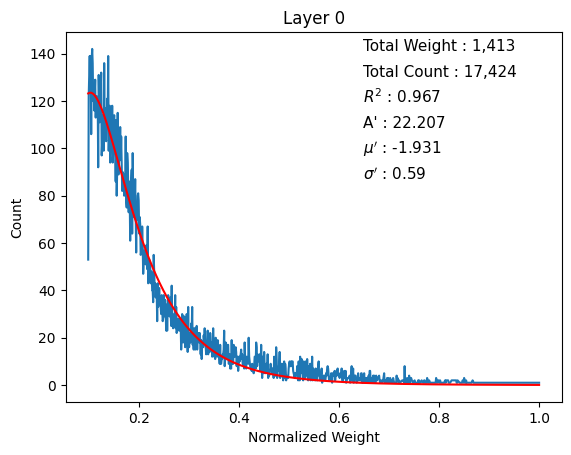

(48,)
(48,) Maxi = 2.6550725   Mini  = 0.6535219
False


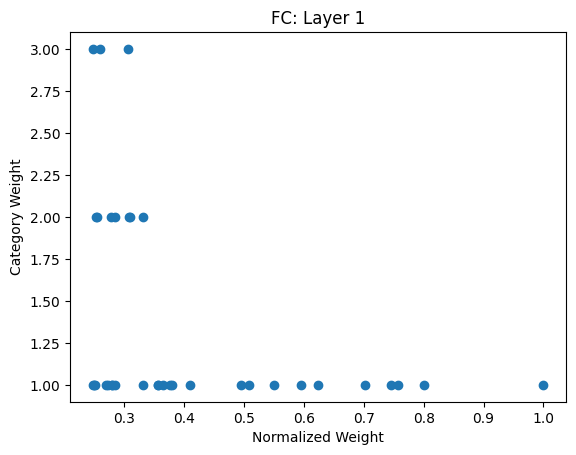

(307200,)
(307200,) Maxi = 1.2697788   Mini  = -1.0600578


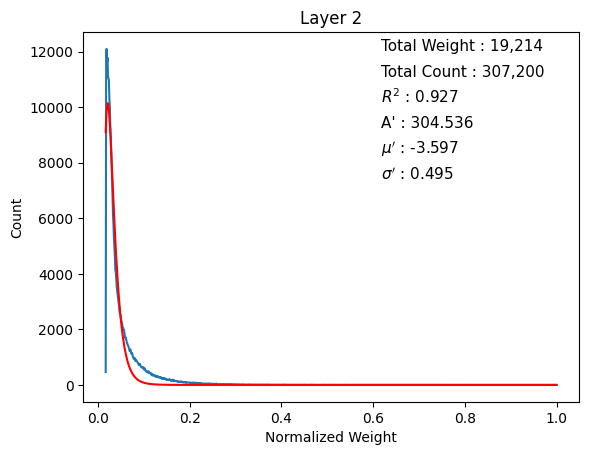

(128,)
(128,) Maxi = 1.6019588   Mini  = 0.8595037


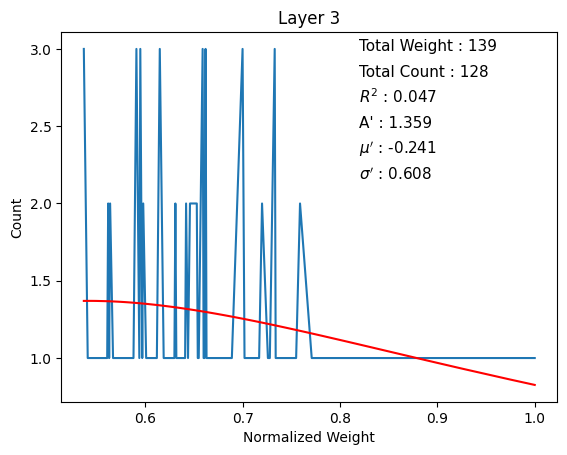

(442368,)
(442368,) Maxi = 0.8203597   Mini  = -1.1574824


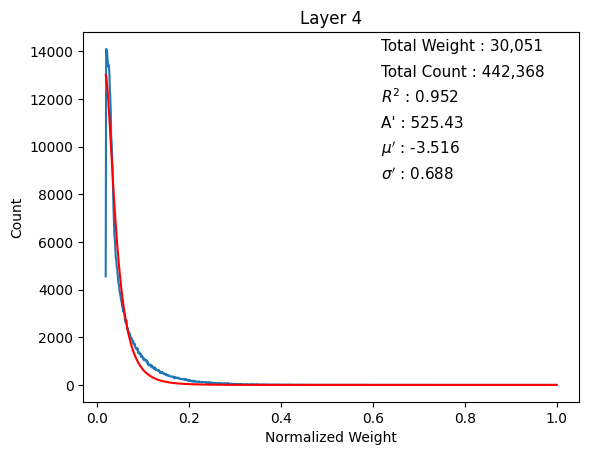

(192,)
(192,) Maxi = 1.4965764   Mini  = 0.9237556
False


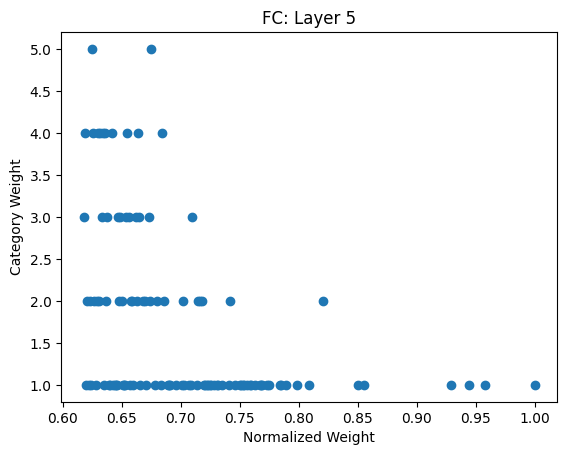

(663552,)
(663552,) Maxi = 0.96128577   Mini  = -0.9227028


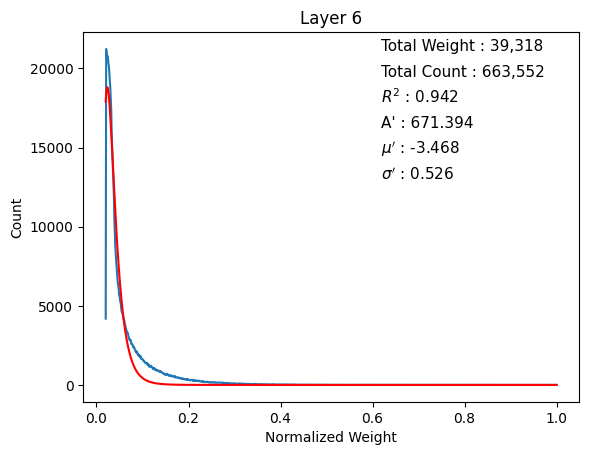

(192,)
(192,) Maxi = 1.4041605   Mini  = 0.9104633
False


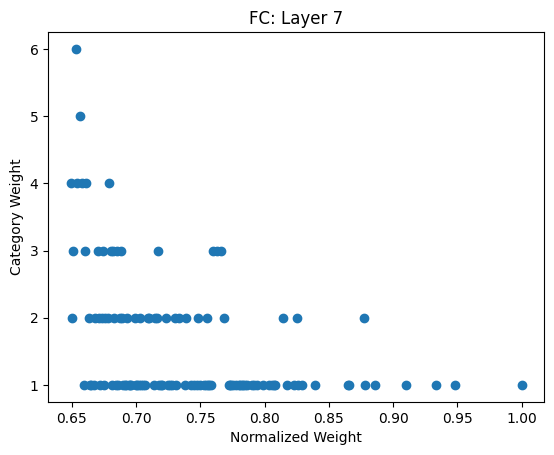

(442368,)
(442368,) Maxi = 0.81641406   Mini  = -0.8445839


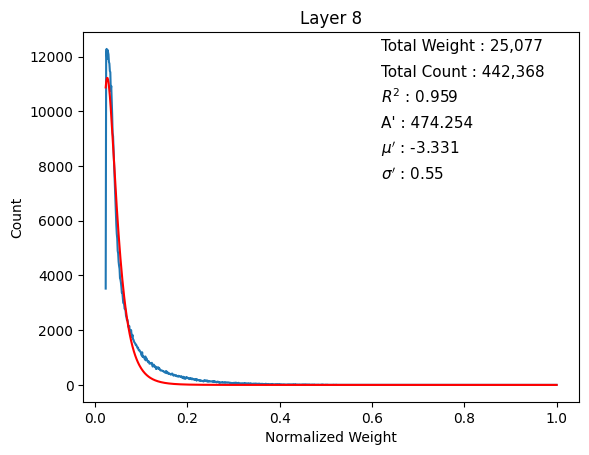

(128,)
(128,) Maxi = 0.9491269   Mini  = 0.8832645


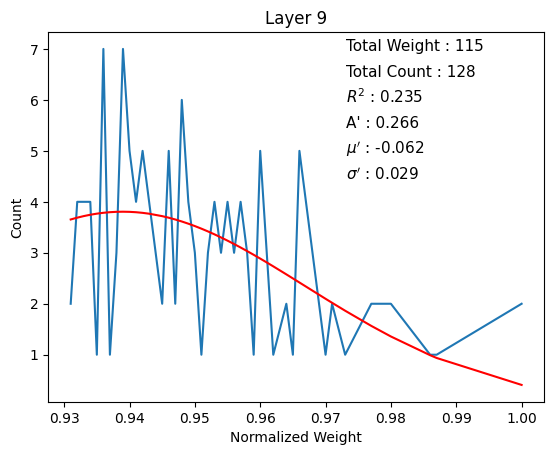

(18874368,)
(18874368,) Maxi = 0.81749225   Mini  = -0.8475644


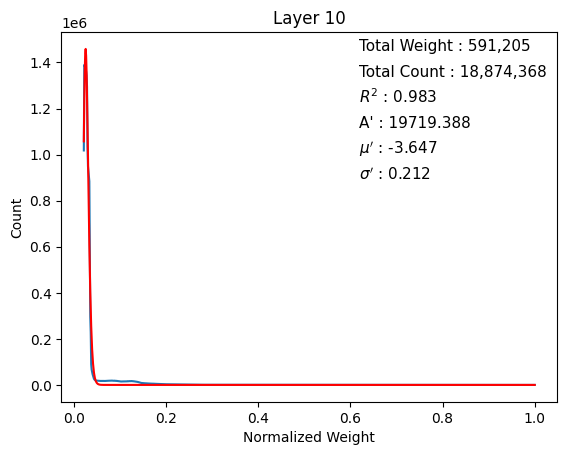

(8388608,)
(8388608,) Maxi = 0.7414779   Mini  = -1.8334024


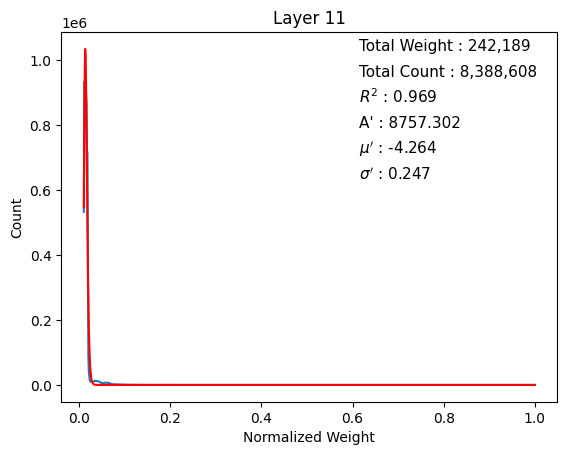

(20480,)
(20480,) Maxi = 0.8854519   Mini  = -0.8275701


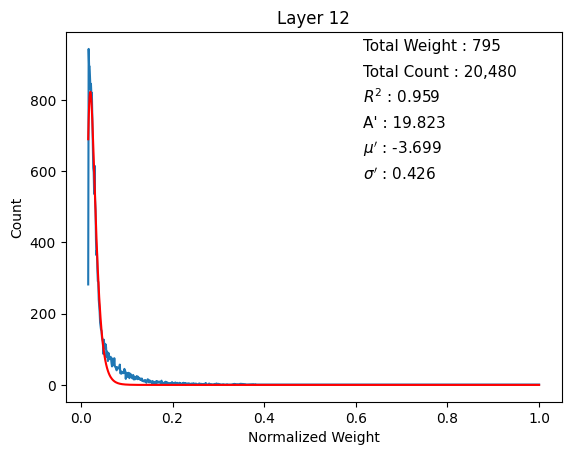

In [10]:
main(r"/kaggle/input/lt-10-5-05/lt-05.pth.tar", "lt-05-10-5")

In [12]:
!zip -r lt-10-5-05.zip /kaggle/working/lt-05-10-5
from IPython.display import FileLink
FileLink(r'lt-10-5-05.zip')

  adding: kaggle/working/lt-05-10-5/ (stored 0%)
  adding: kaggle/working/lt-05-10-5/layer6.png (deflated 10%)
  adding: kaggle/working/lt-05-10-5/layer2.png (deflated 11%)
  adding: kaggle/working/lt-05-10-5/layer4.png (deflated 11%)
  adding: kaggle/working/lt-05-10-5/layer0.png (deflated 6%)
  adding: kaggle/working/lt-05-10-5/layer10.png (deflated 12%)
  adding: kaggle/working/lt-05-10-5/layer12.png (deflated 11%)
  adding: kaggle/working/lt-05-10-5/layer11.png (deflated 13%)
  adding: kaggle/working/lt-05-10-5/layer3.png (deflated 7%)
  adding: kaggle/working/lt-05-10-5/layer8.png (deflated 11%)
  adding: kaggle/working/lt-05-10-5/layer9.png (deflated 6%)


/kaggle/working/lt-10-5-05.zip